In [1]:
type_variables = {
    "infection_rate_infected": float,
    "infection_rate_diseased": float,
    "incubation": int,
    "progression": int,
    "death_rate_infected": float,
    "death_rate_diseased": float,
    "DFTD_start": int,
}

In [3]:

# variables = {  # These match very well, not realitic
#     "birth_rate": 0.055,
#     "maturity_rate": 0.04267,
#     "death_rate_juvenile": 0.006,
#     "death_rate_susceptible": 0.02335,
#     "death_rate_over_population": 2.3e-7,
#     #
#     "infection_rate_infected": 1.675e-05,
#     "infection_rate_diseased": 4e-05,
#     "incubation": 19,
#     "progression": 12,
#     "death_rate_infected": 0.02,
#     "death_rate_diseased": 0.024,
#     "DFTD_start": 95
# }
# variables_orig = variables.copy()

In [2]:
variables = {
    'juvenile_concentration': 0.467, 
    'infected_concentration': 5e-05, 
    'birth_rate': 0.055, 
    'maturity_rate': 0.04267, 
    'infection_rate_infected': 1.675e-05, 
    'infection_rate_diseased': 4e-05, 
    'incubation': 12, 
    'progression': 12, 
    'death_rate_juvenile': 0.006, 
    'death_rate_susceptible': 0.02335, 
    'death_rate_over_population': 2.3e-07, 
    'death_rate_infected': 0.02, 
    'death_rate_diseased': 0.35, 
    'DFTD_start': 95
}
variables_orig = variables.copy()

In [3]:
import json
import subprocess
import sys
import math
import numpy
import re
import matplotlib.pyplot as plt


In [4]:
mean_std_db={}

In [5]:
sweeps={}

In [8]:
def setup_sweep():
    for name,v in type_variables.items():
        sweeps[name] =[ variables[name] ]
        if type_variables[name]==int:
            sweeps[name].insert(0, math.floor(variables[name]*0.95)  )
            sweeps[name].insert(0, math.floor(variables[name]*0.9)  )
            sweeps[name].append(math.ceil(variables[name]*1.1)  )
            sweeps[name].append(math.ceil(variables[name]*1.15)  )
        else:
            sweeps[name].insert(0, variables[name]*0.95  )
            sweeps[name].insert(0, variables[name]*0.9  )
            sweeps[name].append(variables[name]*1.1  )
            sweeps[name].append(variables[name]*1.15  )
        for n,x in enumerate(sweeps[name]):
            x = str(x)
            if '00000' in x:
                x=re.sub(r"00000\d+",'',x)
            elif '99999' in x:
                x=re.sub(r"99999\d+",'9',x)
            sweeps[name][n]=x

setup_sweep()

In [9]:
sweeps

{'infection_rate_infected': ['1.5075e-05',
  '1.59125e-05',
  '1.675e-05',
  '1.8425e-05',
  '1.92625e-05'],
 'infection_rate_diseased': ['3.6e-05',
  '3.8e-05',
  '4e-05',
  '4.4e-05',
  '4.6e-05'],
 'incubation': ['10', '11', '12', '14', '14'],
 'progression': ['10', '11', '12', '14', '14'],
 'death_rate_infected': ['0.018', '0.019', '0.02', '0.022', '0.023'],
 'death_rate_diseased': ['0.315', '0.33249', '0.35', '0.385', '0.40249'],
 'DFTD_start': ['85', '90', '95', '105', '110']}

In [11]:
def compress_vars(var,sweeps):
    ret=''
    for k,v in var.items():
        ret += f" {k}={v}"
    for k,v in sweeps.items():
        ret += f" SWEEP_{k}="
        for vv in v:
            ret+=f"{vv},"
    return ret

In [12]:
def run_remote(var=variables, sweeps=sweeps):
    server = "brian@james.cs.unca.edu"
    cmdpath="/home/brian/research/devils_dftd_modeling/Parameter_Sweeps_ssh/"
    cmd = "run_parameter_sweep.py"
    full_cmd = f"ssh {server} \"{cmdpath}{cmd} {compress_vars(var,sweeps)}\" "
    print(full_cmd)
    p=subprocess.run(full_cmd, shell=True, capture_output=True)
    print(p.stdout.decode())
    print(p.stderr.decode())


In [13]:
run_remote()

ssh brian@james.cs.unca.edu "/home/brian/research/devils_dftd_modeling/Parameter_Sweeps_ssh/run_parameter_sweep.py  juvenile_concentration=0.467 infected_concentration=5e-05 birth_rate=0.055 maturity_rate=0.04267 infection_rate_infected=1.675e-05 infection_rate_diseased=4e-05 incubation=12 progression=12 death_rate_juvenile=0.006 death_rate_susceptible=0.02335 death_rate_over_population=2.3e-07 death_rate_infected=0.02 death_rate_diseased=0.35 DFTD_start=95 SWEEP_infection_rate_infected=1.5075e-05,1.59125e-05,1.675e-05,1.8425e-05,1.92625e-05, SWEEP_infection_rate_diseased=3.6e-05,3.8e-05,4e-05,4.4e-05,4.6e-05, SWEEP_incubation=10,11,12,14,14, SWEEP_progression=10,11,12,14,14, SWEEP_death_rate_infected=0.018,0.019,0.02,0.022,0.023, SWEEP_death_rate_diseased=0.315,0.33249,0.35,0.385,0.40249, SWEEP_DFTD_start=85,90,95,105,110," 
variables = {'juvenile_concentration': '0.467', 'infected_concentration': '5e-05', 'birth_rate': '0.055', 'maturity_rate': '0.04267', 'infection_rate_infected': '

In [14]:
def make_filename(variables):
    cmdpath="/home/brian/research/devils_dftd_modeling/Parameter_Sweeps_ssh/"
    ret = cmdpath+'/ps-'
    for k in sorted(variables.keys()):
        ret+=f"{variables[k]},"
    return ret


In [15]:
def get_mean_std(var):
    f = make_filename(var)
    if f in mean_std_db:
        return mean_std_db[f]
    
    server = "brian@james.cs.unca.edu"
    cmdpath="/home/brian/research/devils_dftd_modeling/Parameter_Sweeps_ssh/"
    full_cmd = f"ssh {server} \"cat {f}.m\" "
    #print(full_cmd)
    p=subprocess.run(full_cmd, shell=True, capture_output=True)
    try:
        resp = p.stdout.decode()
        (m,s) = resp.split(",",2)
        mean_std_db[f] = (float(m),float(s))
        return (float(m),float(s))
    except Exception as e:
        print(f"Caught e={e}")
        print(p.stdout.decode())
        print(p.stderr.decode())


In [16]:
get_mean_std(variables)

(63218.256376855905, 21524.212936452674)

In [17]:
def plot_eresult(eresults): 

    fig, ax1 = plt.subplots(figsize=[12, 6])

    plt.title("Tasmanian Devil Population with DFTD: Observed vs. Simulated", fontsize=18)
    ax1.set_xlabel(f"Time (months) since {dates[0]}", fontsize=16)
    ax1.set_ylabel("Population of Tasmanian Devils", fontsize=16)
    ax1.plot(eresults[0]['time'], obs[0][0], '--', color='black', label='Observed Total')
    ax1.plot(eresults[0]['time'], eresults[0]['Devils'], color='blue', label='Simulated Total')
    ax1.plot(eresults[0]['time'], eresults[0]['Juvenile'], color='purple', alpha=.6, label='Juvenile')
    ax1.plot(eresults[0]['time'], eresults[0]['Susceptible'], color='green', alpha=.6, label='Susceptible')
    ax1.plot(eresults[0]['time'], eresults[0]['Exposed'], color='magenta', alpha=.6, label='Exposed')
    ax1.plot(eresults[0]['time'], eresults[0]['Infected'], color='red', alpha=.6, label='Infected')
    ax1.plot(eresults[0]['time'], eresults[0]['Diseased'], color='cyan', alpha=.6, label='Diseased')
    ax1.plot([variables['DFTD_start'], variables['DFTD_start']], [-3000, carry_cap], '--k', alpha=0.4)
    ax1.text(variables['DFTD_start']-7, 5000, "DFTD Start", rotation="vertical", color="black", fontsize=14)
    ax1.text(variables['DFTD_start']-7, 24000, dates[variables['DFTD_start']], rotation="vertical", color="black", fontsize=14)
    #ax1.set_xlim([0, result[0]['time'][-1]])
    #ax1.set_ylim([-3000, max(devil_pop)*1.25])
    ax1.tick_params(axis='x', labelsize=12)
    ax1.set_yticks([20000,40000,60000])
    ax1.tick_params(axis='y',labelsize=12, labelrotation=90)
    ax1.legend(loc='upper right', fontsize=16)
    ax1.set_ylim([0, carry_cap])
    ax1.set_xlim(0,eresults[0]['time'][-1])
    for n,r in enumerate(eresults):
        if n==0: continue
        ax1.plot(eresults[n]['time'], eresults[n]['Devils'],'b', alpha=0.025)
        ax1.plot(eresults[n]['time'], eresults[n]['Juvenile'], color='purple', alpha=0.025, label='Juvenile')
        ax1.plot(eresults[n]['time'], eresults[n]['Susceptible'], color='green', alpha=0.025, label='Susceptible')
        ax1.plot(eresults[n]['time'], eresults[n]['Exposed'], color='magenta', alpha=0.025, label='Exposed')
        ax1.plot(eresults[n]['time'], eresults[n]['Infected'], color='red', alpha=0.025, label='Infected')
        ax1.plot(eresults[n]['time'], eresults[n]['Diseased'], color='cyan', alpha=0.025, label='Diseased')

    ax2 = plt.axes([0,0,1,1])
    # Manually set the position and relative size of the inset axes within ax1
    ip = InsetPosition(ax1, [0.25,0.55,0.175,0.25])
    ax2.set_axes_locator(ip)
    # Mark the region corresponding to the inset axes on ax1 and draw lines
    # in grey linking the two axes.
    mark_inset(ax1, ax2, loc1=4, loc2=3, fc="none", ec='0.5')

    # plot in the inset
    inst=155
    ined=inst+31
    #ax2.plot(range(len(devil_pop))[inst:ined], devil_pop[inst:ined], '--k', label='Observed Total')
    #ax2.plot(eresults[0]['time'][inst:ined], eresults[0]['Devils'][inst:ined],'b', label="Simulation")
    ax2.plot(eresults[0]['time'], eresults[0]['Juvenile'], color='purple', alpha=.6, label='Juvenile')
    ax2.plot(eresults[0]['time'], eresults[0]['Susceptible'], color='green', alpha=.6, label='Susceptible')
    ax2.plot(eresults[0]['time'], eresults[0]['Exposed'], color='magenta', alpha=.6, label='Exposed')
    ax2.plot(eresults[0]['time'], eresults[0]['Infected'], color='red', alpha=.6, label='Infected')
    ax2.plot(eresults[0]['time'], eresults[0]['Diseased'], color='cyan', alpha=.6, label='Diseased')
    for n,r in enumerate(eresults):
        if n==0: continue
        #ax2.plot(eresults[n]['time'][inst:ined], eresults[n]['Devils'][inst:ined],'b', alpha=0.05)
        ax2.plot(eresults[n]['time'], eresults[n]['Devils'],'b', alpha=0.03)
        ax2.plot(eresults[n]['time'], eresults[n]['Juvenile'], color='purple', alpha=0.025, label='Juvenile')
        ax2.plot(eresults[n]['time'], eresults[n]['Susceptible'], color='green', alpha=0.025, label='Susceptible')
        ax2.plot(eresults[n]['time'], eresults[n]['Exposed'], color='magenta', alpha=0.025, label='Exposed')
        ax2.plot(eresults[n]['time'], eresults[n]['Infected'], color='red', alpha=0.025, label='Infected')
        ax2.plot(eresults[n]['time'], eresults[n]['Diseased'], color='cyan', alpha=0.025, label='Diseased')
        
    ax2.set_xlim(inst,ined-1)
    ax2.set_ylim(2000,7000)
    #ax2.set_yticks([49000,54000])
    ax2.tick_params(axis='y', labelrotation=90)

    #plt.tight_layout()
    #plt.savefig("DevilsDFTD_Data_DFTDsim.pdf")
    print(variables)
    for k,v in variables.items():
        if variables_orig[k] != v:
            print(f"'{k}' = {v}")
    dist_l2 = calculate_distance(eresults)
    print(f"L2 = {dist_l2[0]:.2f} +/-{dist_l2[1]:.2f}")

def calculate_distance(eresults):
    '''return mean/stddev of L2 norm distance'''
    global obs
    dists = numpy.zeros(len(eresults))
    for n,r in enumerate(eresults):
        dists[n] = numpy.linalg.norm(r['Devils']-obs[0][0],2)
    return numpy.average(dists), numpy.std(dists)
    

In [18]:
def plot_sweep(name):
    xvals = numpy.zeros(len(sweeps[name]))
    mvals = numpy.zeros(len(sweeps[name]))
    svals = numpy.zeros(len(sweeps[name]))
    for n,v in enumerate(sweeps[name]):
        c = variables.copy()
        c[name] = type_variables[name](v)
        try:
            (m,s) = get_mean_std(c)
            xvals[n]=c[name]
            mvals[n]=m
            svals[n]=s
        except Exception as e:
            print(f"caught e={e} while name={name} ")
    
    plt.figure(figsize=[12, 6])
    plt.errorbar(xvals,mvals,yerr=svals, capsize=10)
    plt.plot([variables[name], variables[name]],[0, max(mvals)])
    plt.xlabel(name, fontsize=12)
    plt.ylabel('L2 error', fontsize=12)

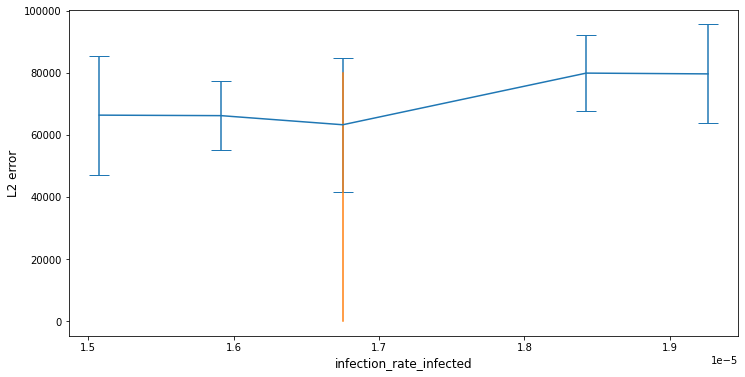

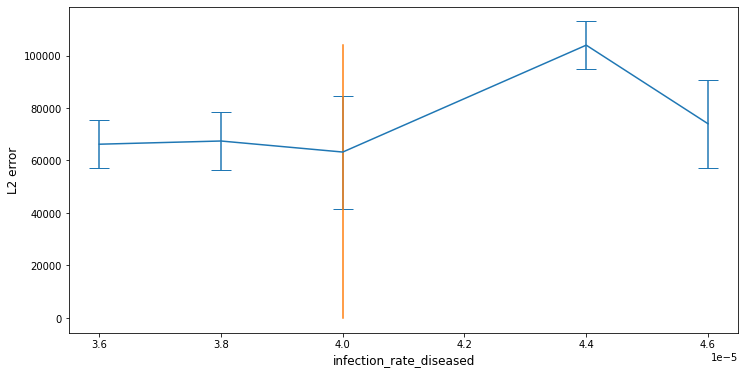

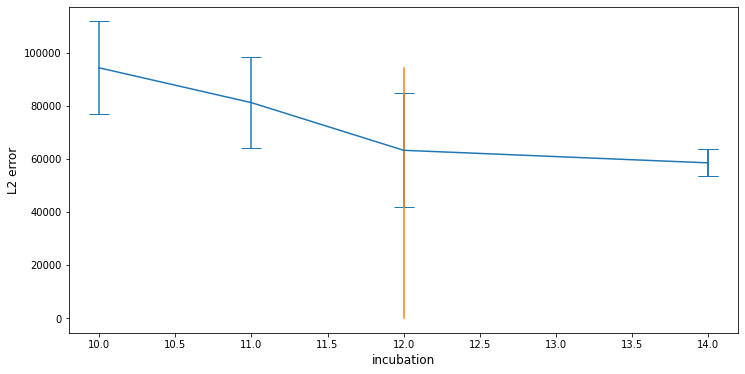

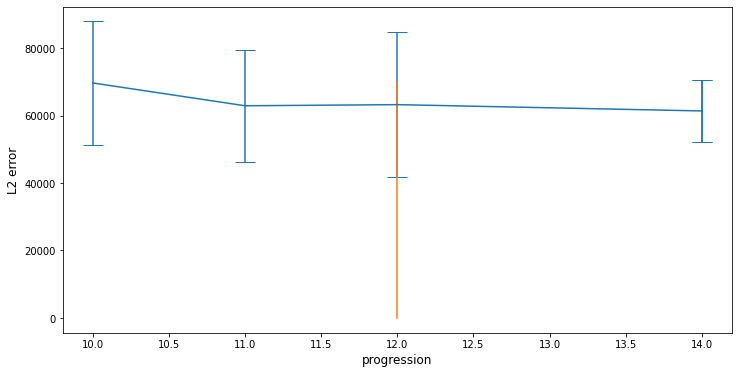

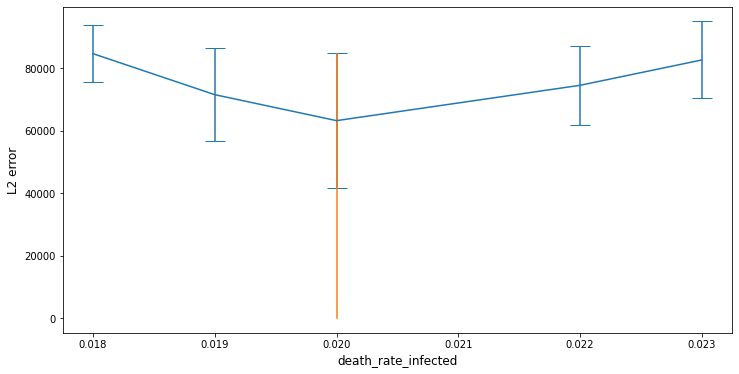

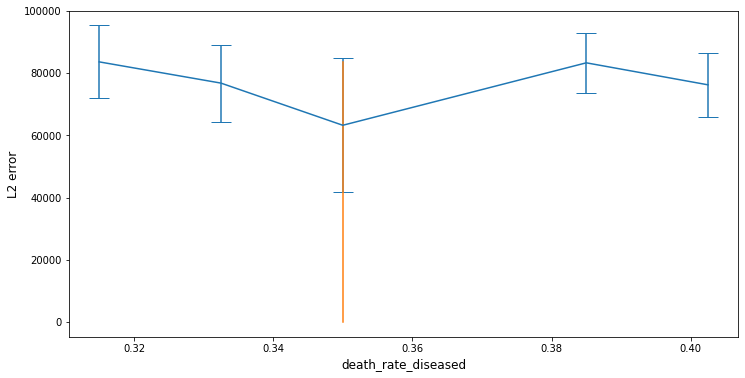

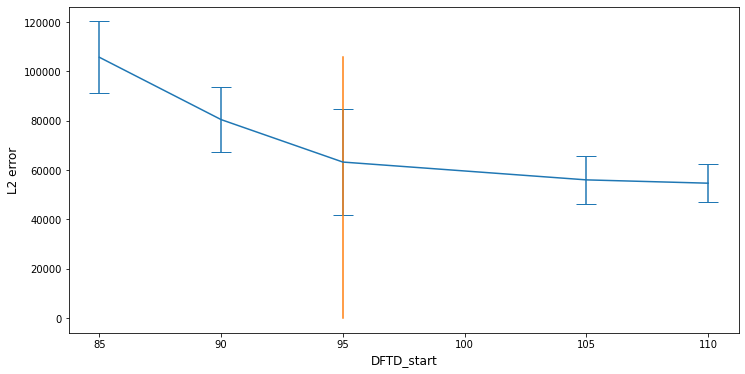

In [20]:
for k in sweeps.keys():
    plot_sweep(k)

In [ ]:
# variables = variables_orig.copy()
# variables['incubation']= 6
# variables['death_rate_infected']=0.1
# variables['death_rate_diseased']=0.35
# variables['infection_rate_infected']=1e-05  #1.675e-05,
# variables['infection_rate_diseased']=1e-05  
# variables['progression'] = 10
# variables['DFTD_start'] = 40